## TTim Exercise 4. Pumping Test with `lmfit`

In [3]:
# import ttim, numpy, matplotlib
from ttim import *
from pylab import *
%matplotlib notebook

This exercise concerns the evaluation of the pumping test near the town of Oude Korendijk, described in the book 'Analysis and evaluation of pumping test data' by Kruseman and de Ridder. A pumping test was conducted in a confined aquifer extending form 18 m to 25 m below surface. The well penetrates the aquifer fully and is pumped at 788 m$^3$/day. Drawdown is measured in two observation wells, one at 30 m from the pumping well and one at 90 m from the pumping well. The data is provided in the files `oudekorendijk30.dat` and `oudekorendijk90.dat`. Time is given in minutes and drawdown in meters. Time is converted to days and drawdown to heads.

In [4]:
observed = loadtxt('oudekorendijk_h30.dat')
to1 = observed[:,0] / 60.0 / 24.0
ho1 = -observed[:,1]
ro1 = 30.0
observed = loadtxt('oudekorendijk_h90.dat')
to2 = observed[:,0] / 60.0 / 24.0
ho2 = -observed[:,1]
ro2 = 90.0
Qo = 788.0

A function is written that creates a ttim model, computes the head at the observation well. The function returns the heads at the observation well when `data=None` and returns the residuals when an array of data is provided with `data`. `tmin` and `tmax` are selected to match the data. Input argument of the function is a `Parameter` object containing the hydraulic conductivity and the specific storage coefficient of the aquifer. 'rdata' is the distance between the well and the observation well. 

In [12]:
from lmfit import Parameters, minimize, fit_report

In [13]:
def residual(p, t=None, rdata=None, data=None):
    vals = p.valuesdict()
    k =  vals['k']
    Ss =  vals['Ss']
    ml = ModelMaq(kaq=k, z=(-18,-25), Saq=Ss, tmin=1e-5, tmax=1)   
    w = Well(ml, xw=0, yw=0, rw=0.1, tsandQ=[(0, 788)], layers=0)
    ml.solve(silent='.')
    hm = ml.head(rdata, 0.0, t, layers=[0])
    if data is None:
        return hm[0]
    else:
        return hm[0] - data  # head in layer 0

Define the parameters $k$ and $S_s$ and give starting values for the parameter optimization

In [14]:
p = Parameters()
p.add('k', value=10.0)
p.add('Ss', value=1e-4)

Determine the optimal parameters using the measurements in the observation well 30 m from the pumping well. Note that the parameter `epsfcn=1e-4` is crucial. This parameter is used to estimate a numerical approximation of the Jacobian matrix. The optimal parameters using the observation well at 30 m are obtained as:

In [16]:
print 'Parameter estimation using data at observation well 30 m'
p30 = minimize(residual, p, kws={'t':to1, 'rdata':ro1, 'data':ho1}, epsfcn=1e-4)
print 
print fit_report(p30.params)

Parameter estimation using data at observation well 30 m
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
[[Variables]]
    k:    68.6395748 +/- 1.438330 (2.10%) (init= 10)
    Ss:   1.6071e-05 +/- 1.58e-06 (9.85%) (init= 0.0001)
[[Correlations]] (unreported correlations are <  0.100)
    C(k, Ss)                     = -0.891 


### Exercise 5a. 

Compute the optimal parameters using the observed head in well 2, at $r=90$ m from the pumping well. Plot the fitted line for both the observation wells in one graph using a semi-log plot. 

In [18]:
print 'Parameter estimation using data at observation well 90 m'
p90 = minimize(residual, p, kws={'t':to2, 'rdata':ro2, 'data':ho2}, epsfcn=1e-4)
print 
print fit_report(p90.params)

Parameter estimation using data at observation well 90 m
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
[[Variables]]
    k:    71.5805516 +/- 1.574150 (2.20%) (init= 10)
    Ss:   2.9110e-05 +/- 1.94e-06 (6.66%) (init= 0.0001)
[[Correlations]] (unreported correlations are <  0.100)
    C(k, Ss)                     = -0.847 


. .

<IPython.core.display.Javascript object>


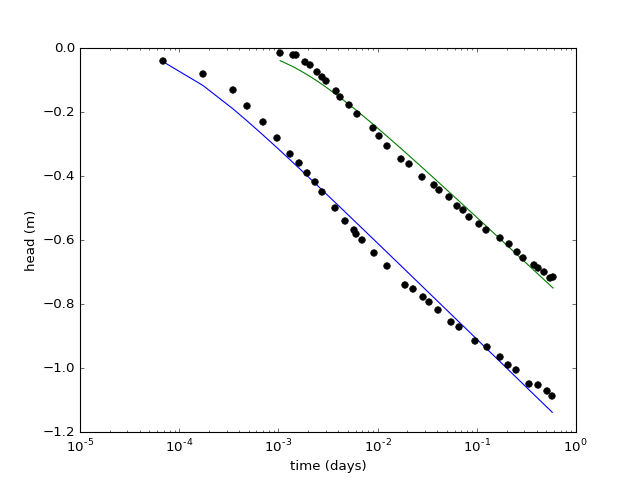

In [19]:
h30 = residual(p30.params, t=to1, rdata=ro1, data=None)
h90 = residual(p90.params, t=to2, rdata=ro2, data=None)
figure()
semilogx(to1, h30, label='30 m')
semilogx(to1, ho1, 'ko')
semilogx(to2, h90, label='90 m')
semilogx(to2, ho2, 'ko')
xlabel('time (days)')
ylabel('head (m)');

Kruseman and de Ridder report optimal values obtained in a variety of ways and on both datasets as $T=370-437$ m$^2$/d and $S=1.6\cdot 10^{-4}-4.1\cdot 10^{-4}$. Optimal values with this first analysis are a bit higher for $T$ and a bit lower for $S$, while the fit is pretty good.

In [9]:
print '30 m T and S:', p30.params['k'].value * 7, p30.params['Ss'].value * 7
print '90 m T and S:', p90.params['k'].value * 7, p90.params['Ss'].value * 7

30 m T and S: 480.477023725 0.000112499108037
90 m T and S: 501.06386131 0.000203767382683


### Wellbore storage
Kruseman and De Ridder don't include wellbore storage in their well, although early response of the well suggests wellbore storage is not negligible. 

### Question 5b. 
Include wellbore storage and check whether it gives a better fit (lower sum of squared errors). Use a well radius for wellbore storage of $r_c=0.2$ m. Report the fitted parameters for both observation wells. Plot the data and fitted lines for both wells in one graph.

In [20]:
def residual(p, t=None, rdata=None, data=None):
    vals = p.valuesdict()
    k =  vals['k']
    Ss =  vals['Ss']
    rc = vals['rc']
    ml = ModelMaq(kaq=k, z=(-18,-25), Saq=Ss, tmin=1e-5, tmax=1)   
    w = Well(ml, xw=0, yw=0, rw=0.1, tsandQ=[(0, 788)], layers=0, rc=rc)
    ml.solve(silent='.')
    hm = ml.head(rdata, 0.0, t, layers=[0])
    if data is None:
        return hm[0]
    else:
        return hm[0] - data  # head in layer 0
    
p = Parameters()
p.add('k', value=10.0)
p.add('Ss', value=1e-4)
p.add('rc', value=0, vary=False)

Parameter estimation using data at observation well 30 m with wellbore storage
. . . . . . . . . . . . . . . . . . . . . . . . . . . . .
[[Variables]]
    k:    74.7090458 +/- 1.031020 (1.38%) (init= 10)
    Ss:   9.4804e-06 +/- 6.98e-07 (7.36%) (init= 0.0001)
    rc:   0.2 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(k, Ss)                     = -0.907 
Parameter estimation using data at observation well 90 m with wellbore storage
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
[[Variables]]
    k:    73.2474398 +/- 1.385888 (1.89%) (init= 10)
    Ss:   2.6501e-05 +/- 1.57e-06 (5.92%) (init= 0.0001)
    rc:   0.2 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(k, Ss)                     = -0.848 
30 m T and S: 522.9633212 6.63627945489e-05
90 m T and S: 512.732079008 0.000185510046453
. .

<IPython.core.display.Javascript object>


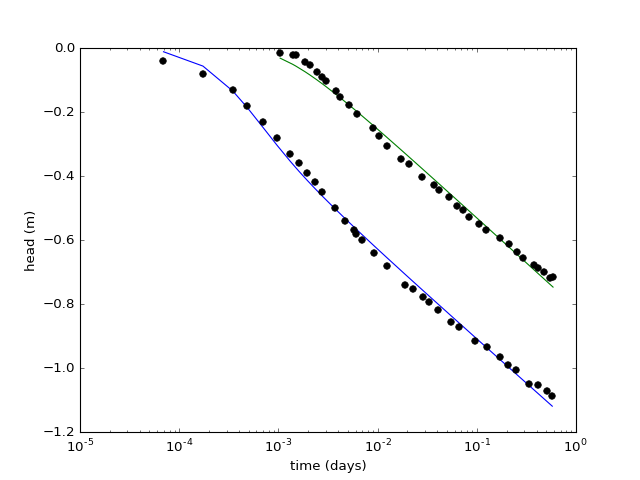

In [21]:
p['rc'].value = 0.2
p['rc'].vary = False

print 'Parameter estimation using data at observation well 30 m with wellbore storage'
p30rc = minimize(residual, p, kws={'t':to1, 'rdata':ro1, 'data':ho1}, epsfcn=1e-4)
print 
print fit_report(p30rc.params)

print 'Parameter estimation using data at observation well 90 m with wellbore storage'
p90rc = minimize(residual, p, kws={'t':to2, 'rdata':ro2, 'data':ho2}, epsfcn=1e-4)
print 
print fit_report(p90rc.params)

print '30 m T and S:', p30rc.params['k'].value * 7, p30rc.params['Ss'].value * 7
print '90 m T and S:', p90rc.params['k'].value * 7, p90rc.params['Ss'].value * 7

h30rc = residual(p30rc.params, t=to1, rdata=ro1, data=None)
h90rc = residual(p90rc.params, t=to2, rdata=ro2, data=None)
figure()
semilogx(to1, h30rc, label='30 m')
semilogx(to1, ho1, 'ko')
semilogx(to2, h90rc, label='90 m')
semilogx(to2, ho2, 'ko')
xlabel('time (days)')
ylabel('head (m)');

### Question 5c

Estimate optimal parameters using the observations at both wells simultaneously. Report the fitted values. Create a graph showing the data and both fitted lines. Hint: you may want to use the `np.hstack` command to stack two arrays together back to back. 

### Question not to be included

Kruseman and De Ridder suggests that the confined aquifer may be underlain by a clay layer that leaks a bit of water. This may be seen from the data, where the observations seem to indicate a slight leveling-off of the drawdown and then a second increase due to release from the aquifer below. Mind you this is all fairly suttle, and may not be realistic, but it is easy to try to simulate the aquifer with an additional leaky layer. TTim requires this additional layer to be on top of the aquifer, but that gives the exact same mathematical solution as at the bottom of the aquifer (for a system consisting of one aquifer). The thickness of the additional layer is not important if the storage of the leaky layer is neglected. When the model is fitted, it should be prevented that one of the parameters becomes negative, which is obviously unrealistic and may lead to impossible solutions. Such safeguards are not built in here, and the optimization algorithm is able to find a solution, although quite a few iterations are needed. 

In [11]:
def residual_semi(p, t=None, rdata=None, data=None):
    vals = p.valuesdict()
    k =  vals['k']
    Ss =  vals['Ss']
    rc = vals['rc']
    c = vals['c']
    ml = ModelMaq(kaq=k, z=(-10, -18,-25), Saq=Ss, c=c, topboundary='semi', tmin=1e-5, tmax=1)   
    w = Well(ml, xw=0, yw=0, rw=0.1, tsandQ=[(0, 788)], layers=0, rc=rc)
    ml.solve(silent='.')
    hm = ml.head(rdata, 0.0, t, layers=[0])
    if data is None:
        return hm[0]
    else:
        return hm[0] - data  # head in layer 0

In [12]:
p.add('c', value=5000, min=1, max=1e5)
print 'Parameter estimation using data at observation well 30 m, wellbore storage and semi confining layer'
p30rcsemi = minimize(residual_semi, p, kws={'t':to1, 'rdata':ro1, 'data':ho1}, epsfcn=1e-4)
print 
print fit_report(p30rcsemi.params)

Parameter estimation using data at observation well 30 m, wellbore storage and semi confining layer
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
[[Variables]]
    k:    69.2868718 +/- 1.048104 (1.51%) (init= 10)
    Ss:   1.1747e-05 +/- 6.53e-07 (5.56%) (init= 0.0001)
    rc:   0.2 (fixed)
    c:    7944.13150 +/- 1.55e+03 (19.54%) (init= 5000)
[[Correlations]] (unreported correlations are <  0.100)
    C(k, Ss)                     = -0.904 
    C(k, c)                      =  0.884 
    C(Ss, c)                     = -0.716 


In [13]:
print 'Parameter estimation using data at observation well 90 m, wellbore storage and semi confining layer'
p90rcsemi = minimize(residual_semi, p, kws={'t':to2, 'rdata':ro2, 'data':ho2}, epsfcn=1e-4)
print 
print fit_report(p90rcsemi.params)

Parameter estimation using data at observation well 90 m, wellbore storage and semi confining layer
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
[[Variables]]
    k:    63.5216901 +/- 1.399284 (2.20%) (init= 10)
    Ss:   3.0175e-05 +/- 1.09e-06 (3.62%) (init= 0.0001)
    rc:   0.2 (fixed)
    c:    2631.12270 +/- 712.0474 (27.06%) (init= 5000)
[[Correlations]] (unreported correlations are <  0.100)
    C(k, c)                      =  0.913 
    C(k, Ss)                     = -0.780 
    C(Ss, c)                     = -0.596 


. .

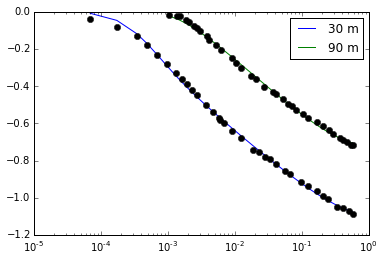

In [20]:
h30rcsemi = residual_semi(p30rcsemi.params, t=to1, rdata=ro1, data=None)
h90rcsemi = residual_semi(p90rcsemi.params, t=to2, rdata=ro2, data=None)
semilogx(to1, h30rcsemi, label='30 m')
semilogx(to1, ho1, 'ko')
semilogx(to2, h90rcsemi, label='90 m')
semilogx(to2, ho2, 'ko')
legend(loc='best')

### Exercise
Find optimal values for $k$ and $S_s$ for the measurements at the observation well at $r=90$ m.